In [288]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datetime import datetime
sns.set_style('darkgrid')

In [289]:
train1 = pd.read_csv('train.csv')

In [290]:
test1 = pd.read_csv('test.csv')

In [291]:
def pre_processing(df,train=True):
    
    if train == True:
        
        # Pre processing train data
        #  Adding time and month to the dataframe using datatime column
        time=[]
        month=[]
        for i in df['datetime']:
                dt_object2 = datetime.strptime(i, "%Y-%m-%d %H:%M:%S")
                time.append(dt_object2.hour)
                month.append(dt_object2.month)
        df['time'] = pd.DataFrame(time)
        df['time'] = df['time'].astype(float)
        df['month'] = pd.DataFrame(month)
        df['month'] = df['month'].astype(float)
        
        # Dropping datetime column
        df.drop('datetime',axis=1,inplace=True) 
        # Dropping holiday column as it is highly correlated to 'workingday' column
        df.drop('holiday',axis=1,inplace=True) 
        # Dropping atemp column as it is highly correlated to 'temp' column
        df = df.drop('atemp',axis=1) # No use 

        
        # One hot encoding on categorical columns.
        df = pd.get_dummies(df,columns=['season','weather'],drop_first=True)  
        
        # Median imputation if any
        for i in df.columns:
            df[i].fillna(value = df[i].median())
        return df
    
    
    else:
        # Pre processing Test data
        #  Adding time and month to the dataframe using datatime column
        time=[]
        month=[]
        for i in df['datetime']:
                dt_object2 = datetime.strptime(i, "%Y-%m-%d %H:%M:%S")
                time.append(dt_object2.hour)
                month.append(dt_object2.month)
        df['time'] = pd.DataFrame(time)
        df['time'] = df['time'].astype(float)
        df['month'] = pd.DataFrame(month)
        df['month'] = df['month'].astype(float)
        
        # Dropping datetime column
        df.drop('datetime',axis=1,inplace=True) 
        # Dropping holiday column as it is highly correlated to 'workingday' column
        df.drop('holiday',axis=1,inplace=True) 
        # Dropping atemp column as it is highly correlated to 'temp' column
        df = df.drop('atemp',axis=1) 
        
        # One hot encoding on categorical columns.
        df = pd.get_dummies(df,columns=['season','weather'],drop_first=True)  
        
         # Median imputation if there are any null values
        for i in df.columns:
            df[i].fillna(value = df[i].median())
            

        return df  

In [292]:
def model(df):
    global nw_count_pred
    global count_pred
    global final_count
    global model_1
    global model_2
    global model_3
    global model_4

    
    # Segregating data based on 'workingday' column
    work_day = df[df['workingday']==1] 
    non_work_day = df[df['workingday']==0]
    # Model for registered
    x = work_day.drop(['casual','registered','count'],axis = 1)
    y = work_day.registered
    # Dividing the data into train and test
    from sklearn.model_selection import train_test_split
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.30 ,random_state = 2)
    
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.ensemble import AdaBoostRegressor

    # Finding best parameters for RandomForestRegressor
    rf = RandomForestRegressor(random_state=0)
    rf_params = {'n_estimators':np.arange(25,150,25),'max_depth':np.arange(1,11,2),'min_samples_leaf':np.arange(2,15,3)}
    from sklearn.model_selection import GridSearchCV
    gs_rf = GridSearchCV(rf,rf_params,cv=3)
    gs_rf.fit(x_train,y_train)
    
    a = gs_rf.best_params_
    
    # Fitting the model with best params on the whole data
    RF = RandomForestRegressor(n_estimators=a['n_estimators'],max_depth=a['max_depth'],min_samples_leaf=a['min_samples_leaf'],random_state=0)
    
    model_1 = RF.fit(x,y)
    work_day_reg_pred = model_1.predict(x)
    from sklearn.metrics import mean_squared_log_error
    msle=mean_squared_log_error(work_day_reg_pred,y)
    rmsle=np.sqrt(msle)
    print('RMLSE for the wr:',rmsle) 
    # Plotting important features
    importances = RF.feature_importances_
    plt.title('Registered Feature Importances')
    plt.barh(range(len(importances)), importances, color='g', align='center')
    plt.yticks(range(len(importances)), x.columns)
    plt.xlabel('Relative Importance')
    plt.show()
    
    
    # Model for registered
    x = work_day.drop(['casual','registered','count'],axis = 1)
    y = work_day.casual
    # Dividing the data into train and test
    from sklearn.model_selection import train_test_split
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.30 ,random_state = 2)
    
    from sklearn.ensemble import RandomForestRegressor
    # Finding best parameters for RandomForestRegressor
    rf = RandomForestRegressor(random_state=0)
    rf_params = {'n_estimators':np.arange(25,150,25),'max_depth':np.arange(1,11,2),'min_samples_leaf':np.arange(2,15,3)}
    from sklearn.model_selection import GridSearchCV
    gs_rf = GridSearchCV(rf,rf_params,cv=3)
    gs_rf.fit(x_train,y_train)
    
    a = gs_rf.best_params_
    
    # Fitting the model with best params on the whole data
    RF = RandomForestRegressor(n_estimators=a['n_estimators'],max_depth=a['max_depth'],min_samples_leaf=a['min_samples_leaf'],random_state=0)
    
    model_2 = RF.fit(x,y)

    work_day_casual_pred = model_2.predict(x)
    from sklearn.metrics import mean_squared_log_error
    msle=mean_squared_log_error(work_day_casual_pred,y)
    rmsle=np.sqrt(msle)
    print('RMLSE for the wc:',rmsle) 
    
    # Plotting important features
    importances = RF.feature_importances_
    plt.title('Casual-Feature Importances')
    plt.barh(range(len(importances)), importances, color='g', align='center')
    plt.yticks(range(len(importances)), x.columns)
    plt.xlabel('Relative Importance')
    plt.show()
    
    
    # Adding the above predicted values of casual and registered
    count_pred = pd.DataFrame()
    count_pred['casual'] = work_day_casual_pred
    count_pred['registered'] = work_day_reg_pred
    count_pred['count_pred'] = work_day_casual_pred+work_day_reg_pred
    count_pred.index = x.index
    
    
     # Checking Root mean suared error of predicted count
    from sklearn.metrics import mean_squared_log_error
    msle=mean_squared_log_error(work_day['count'],count_pred['count_pred'])
    rmsle=np.sqrt(msle)
    print('RMLSE for a working day:',rmsle)
    
    # Model for registered
    x = non_work_day.drop(['casual','registered','count'],axis = 1)
    y = non_work_day.registered
    # Dividing the data into train and test
    from sklearn.model_selection import train_test_split
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.30 ,random_state = 2)
    
    from sklearn.ensemble import RandomForestRegressor
    # Finding best parameters for RandomForestRegressor
    rf = RandomForestRegressor(random_state=0)
    rf_params = {'n_estimators':np.arange(25,150,25),'max_depth':np.arange(1,11,2),'min_samples_leaf':np.arange(2,15,3)}
    from sklearn.model_selection import GridSearchCV
    gs_rf = GridSearchCV(rf,rf_params,cv=3)
    gs_rf.fit(x_train,y_train)
    
    a = gs_rf.best_params_
    
    # Fitting the model with best params on the whole data
    RF = RandomForestRegressor(n_estimators=a['n_estimators'],max_depth=a['max_depth'],min_samples_leaf=a['min_samples_leaf'],random_state=0)
    
    model_3 = RF.fit(x,y)

    non_work_day_reg_pred = model_3.predict(x)
    from sklearn.metrics import mean_squared_log_error
    msle=mean_squared_log_error(non_work_day_reg_pred,y)
    rmsle=np.sqrt(msle)
    print('RMLSE for the nwr:',rmsle) 
    
    # Plotting important features
    importances = RF.feature_importances_
    plt.title('Registered Feature Importances')
    plt.barh(range(len(importances)), importances, color='g', align='center')
    plt.yticks(range(len(importances)), x.columns)
    plt.xlabel('Relative Importance')
    plt.show()
    
    
    # Model for registered
    x = non_work_day.drop(['casual','registered','count'],axis = 1)
    y = non_work_day.casual
    # Dividing the data into train and test
    from sklearn.model_selection import train_test_split
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.30 ,random_state = 2)
    
    from sklearn.ensemble import RandomForestRegressor
    # Finding best parameters for RandomForestRegressor
    rf = RandomForestRegressor(random_state=0)
    rf_params = {'n_estimators':np.arange(25,150,25),'max_depth':np.arange(1,11,2),'min_samples_leaf':np.arange(2,15,3)}
    from sklearn.model_selection import GridSearchCV
    gs_rf = GridSearchCV(rf,rf_params,cv=3)
    gs_rf.fit(x_train,y_train)
    
    a = gs_rf.best_params_
    
    # Fitting the model with best params on the whole data
    RF = RandomForestRegressor(n_estimators=a['n_estimators'],max_depth=a['max_depth'],min_samples_leaf=a['min_samples_leaf'],random_state=0)
    
    model_4 = RF.fit(x,y)

    non_work_day_casual_pred = model_4.predict(x)
    from sklearn.metrics import mean_squared_log_error
    msle=mean_squared_log_error(non_work_day_casual_pred,y)
    rmsle=np.sqrt(msle)
    print('RMLSE for the nwc:',rmsle) 
    
    
    # Plotting important features
    importances = RF.feature_importances_
    plt.title('Casual-Feature Importances')
    plt.barh(range(len(importances)), importances, color='g', align='center')
    plt.yticks(range(len(importances)), x.columns)
    plt.xlabel('Relative Importance')
    plt.show()
    

    nw_count_pred = pd.DataFrame()
    nw_count_pred['casual'] = non_work_day_casual_pred
    nw_count_pred['registered'] = non_work_day_reg_pred
    nw_count_pred['nw_count_pred'] = non_work_day_casual_pred+non_work_day_reg_pred
    nw_count_pred.index = x.index

    
    from sklearn.metrics import mean_squared_log_error
    msle=mean_squared_log_error(non_work_day['count'],nw_count_pred['nw_count_pred'])
    rmsle=np.sqrt(msle)
    print('RMLSE for a non working day:',rmsle)
    
    final_count = pd.DataFrame()
    final_count = pd.concat([count_pred['count_pred'],nw_count_pred['nw_count_pred']])
    final_count.sort_index(inplace = True)
    
         # Checking Root mean suared error of predicted count
    from sklearn.metrics import mean_squared_log_error
    msle=mean_squared_log_error(df['count'],final_count)
    rmsle=np.sqrt(msle)
    print('RMLSE for the whole data:',rmsle)


RMLSE for the wr: 0.35828603845213014


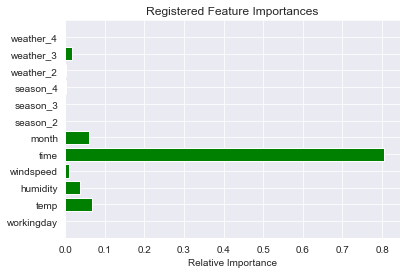

RMLSE for the wc: 0.47384540209764753


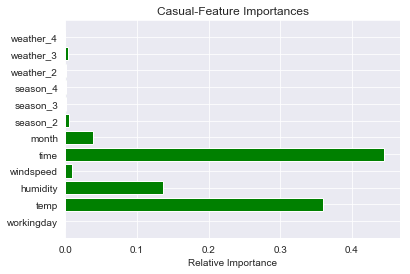

RMLSE for a working day: 0.34882152854162574
RMLSE for the nwr: 0.36758325566991074


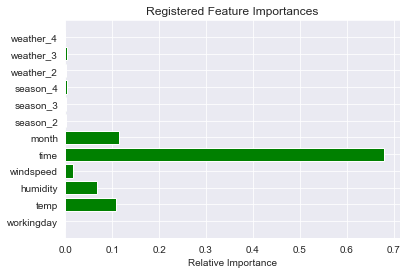

RMLSE for the nwc: 0.45488355422120313


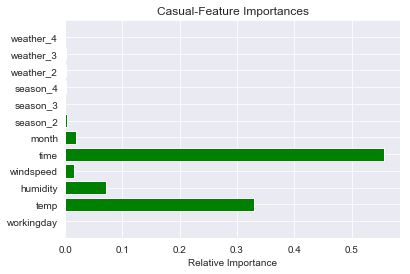

RMLSE for a non working day: 0.358245884870285
RMLSE for the whole data: 0.35185650622124004


In [293]:
a = pre_processing(train1,train=True)
model(a)

In [294]:
def model_test(df):
    global nw_count_pred
    global count_pred
    global final_count
    
    # Segregating data based on 'workingday' column
    work_day = df[df['workingday']==1] 
    non_work_day = df[df['workingday']==0]
    # Model for registered
    x = work_day

    work_day_reg_pred = model_1.predict(x)
    

    # Model for registered
    x = work_day

    work_day_casual_pred = model_2.predict(x)

    
    # Adding the above predicted values of casual and registered
    count_pred = pd.DataFrame()
    count_pred['casual'] = work_day_casual_pred
    count_pred['registered'] = work_day_reg_pred
    count_pred['count_pred'] = work_day_casual_pred+work_day_reg_pred
    count_pred.index = x.index
    

    # Model for registered
    x = non_work_day
    non_work_day_reg_pred = model_3.predict(x)
    

    # Model for registered
    x = non_work_day
    non_work_day_casual_pred = model_4.predict(x)


    nw_count_pred = pd.DataFrame()
    nw_count_pred['casual'] = non_work_day_casual_pred
    nw_count_pred['registered'] = non_work_day_reg_pred
    nw_count_pred['nw_count_pred'] = non_work_day_casual_pred+non_work_day_reg_pred
    nw_count_pred.index = x.index


    
    final_count = pd.DataFrame()
    final_count = pd.concat([count_pred['count_pred'],nw_count_pred['nw_count_pred']])
    final_count.sort_index(inplace = True)
    


In [295]:
a = pre_processing(test1,train=False)
model_test(a)


In [296]:
ss = pd.read_csv('sampleSubmission.csv')
ss.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [300]:
ss['count'] = final_count

In [301]:
ss.head()

,datetime,count
0,2011-01-20 00:00:00,12.237781
1,2011-01-20 01:00:00,6.016530
2,2011-01-20 02:00:00,4.656349
3,2011-01-20 03:00:00,2.871552
4,2011-01-20 04:00:00,2.592699


In [302]:
ss.to_csv('bike_submission9.csv',index=False)
